In [21]:

import pandas as pd
import numpy as np
import pickle
from datetime import datetime

import sys
sys.path.insert(0, "..")   
from src.model_utils import train
from src.utils import build_feature_and_label_cols
from src.plot_util import plot_all_sids_losses, plot_loss_per_sid, plot_median_iqr_loss, plot_final_percent_mae_per_sid



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-06-07'

In [4]:
# load
df = pd.read_excel("../output/data/20250607_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx")
df.head()

,start_date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_season_cos_7,y_season_cos_8,y_season_cos_9,y_season_cos_10,y_season_cos_11,y_season_cos_12,y_season_cos_13,y_season_cos_14,y_season_cos_15,y_season_cos_16
0,2013-01-09,3_1047679,3,1047679,398.0,520.0,543.0,910.0,784.0,467.0,...,0.677615,0.690173,0.702527,0.714673,0.726608,0.738326,0.749826,0.761104,0.772157,0.782980
1,2013-01-25,3_1047679,3,1047679,224.0,520.0,474.0,251.0,302.0,288.0,...,0.852078,0.860961,0.869589,0.877960,0.886071,0.893919,0.901502,0.908818,0.915864,0.922640
2,2013-02-10,3_1047679,3,1047679,245.0,308.0,243.0,286.0,231.0,267.0,...,0.962309,0.966848,0.971100,0.975065,0.978740,0.982126,0.985220,0.988023,0.990532,0.992749
3,2013-02-26,3_1047679,3,1047679,173.0,352.0,231.0,292.0,525.0,736.0,...,1.000000,0.999852,0.999407,0.998667,0.997630,0.996298,0.994671,0.992749,0.990532,0.988023
4,2013-03-14,3_1047679,3,1047679,429.0,419.0,504.0,623.0,293.0,250.0,...,0.962309,0.957485,0.952378,0.946988,0.941317,0.935368,0.929141,0.922640,0.915864,0.908818


In [6]:
df["start_date"].min(), df["start_date"].max()

(Timestamp('2013-01-09 00:00:00'), Timestamp('2017-07-15 00:00:00'))

In [7]:
df.dtypes

start_date         datetime64[ns]
store_item                 object
store                       int64
item                        int64
sales_day_1               float64
                        ...      
y_season_cos_12           float64
y_season_cos_13           float64
y_season_cos_14           float64
y_season_cos_15           float64
y_season_cos_16           float64
Length: 420, dtype: object

In [8]:
df.columns

Index(['start_date', 'store_item', 'store', 'item', 'sales_day_1',
       'sales_day_2', 'sales_day_3', 'sales_day_4', 'sales_day_5',
       'sales_day_6',
       ...
       'y_season_cos_7', 'y_season_cos_8', 'y_season_cos_9', 'y_season_cos_10',
       'y_season_cos_11', 'y_season_cos_12', 'y_season_cos_13',
       'y_season_cos_14', 'y_season_cos_15', 'y_season_cos_16'],
      dtype='object', length=420)

In [9]:
df.shape

(10386, 420)

In [10]:
window_size = 16
meta_cols, feature_cols, label_cols, y_sales_features, y_cyclical_features = build_feature_and_label_cols(window_size)



In [12]:
print(len(feature_cols))
print(len(label_cols))
print(len(y_sales_features))
print(len(y_cyclical_features))
print(len(meta_cols))
print(len(df.columns))


208
208
48
160
4
420


In [13]:
weights_df= pd.read_excel("../output/data/top_10_item_weights.xlsx")

In [14]:
weights_df

,item,weight
0,114790,1.00
1,305229,1.00
2,314384,1.00
3,364606,1.00
4,502331,1.25
5,567623,1.00
6,581078,1.00
7,582864,1.25
8,584028,1.25
9,1047679,1.00


In [15]:
hist_df, summary_df, models_dict = train(
    df            = df,
    weights_df    = weights_df,
    feature_cols  = feature_cols,
    label_cols    = label_cols,
    y_cyclical_features = y_cyclical_features,
    y_sales_features = y_sales_features,
    item_col      = "item",
    train_frac    = 0.8,
    batch_size    = 32,
    lr            = 1e-3,
    epochs        = 100,
    seed          = 2025
    )    

[3_1047679] Epoch 1/100 train_RMSLE 5.9859, train_MAE 37.8954, train_%MAE 0.7453, test_RMSLE 0.3891, test_MAE 32.2855, test_%MAE 0.7308
[3_1047679] Epoch 2/100 train_RMSLE 5.4927, train_MAE 36.2497, train_%MAE 0.7129, test_RMSLE 0.3572, test_MAE 31.2982, test_%MAE 0.7085
[3_1047679] Epoch 3/100 train_RMSLE 5.0682, train_MAE 34.7738, train_%MAE 0.6839, test_RMSLE 0.3359, test_MAE 30.4785, test_%MAE 0.6899
[3_1047679] Epoch 4/100 train_RMSLE 4.7962, train_MAE 32.4595, train_%MAE 0.6384, test_RMSLE 0.3210, test_MAE 29.5953, test_%MAE 0.6699
[3_1047679] Epoch 5/100 train_RMSLE 4.5809, train_MAE 30.5623, train_%MAE 0.6011, test_RMSLE 0.3072, test_MAE 28.4390, test_%MAE 0.6438
[3_1047679] Epoch 6/100 train_RMSLE 4.3843, train_MAE 29.7169, train_%MAE 0.5844, test_RMSLE 0.2970, test_MAE 28.1940, test_%MAE 0.6382
[3_1047679] Epoch 7/100 train_RMSLE 4.2381, train_MAE 29.1336, train_%MAE 0.5730, test_RMSLE 0.2900, test_MAE 27.9089, test_%MAE 0.6318
[3_1047679] Epoch 8/100 train_RMSLE 4.1354, trai

In [16]:
hist_df.head(3)


,store_item,epoch,train_loss,train_mae,train_percent_mae,test_loss,test_mae,test_percent_mae
0,3_1047679,1,5.985926,37.895443,0.745289,0.389087,32.285539,0.730843
1,3_1047679,2,5.492652,36.249691,0.712922,0.357152,31.298199,0.708493
2,3_1047679,3,5.068219,34.773818,0.683896,0.335865,30.478494,0.689937


In [17]:
summary_df.head(3)

,store_item,final_train_loss,final_test_loss,final_train_percent_mae,final_test_percent_mae
0,3_1047679,2.172756,0.159017,0.490390,0.645212
1,3_114790,2.411111,0.184102,0.278955,0.399376
2,3_305229,1.971142,0.148171,0.294508,0.367259


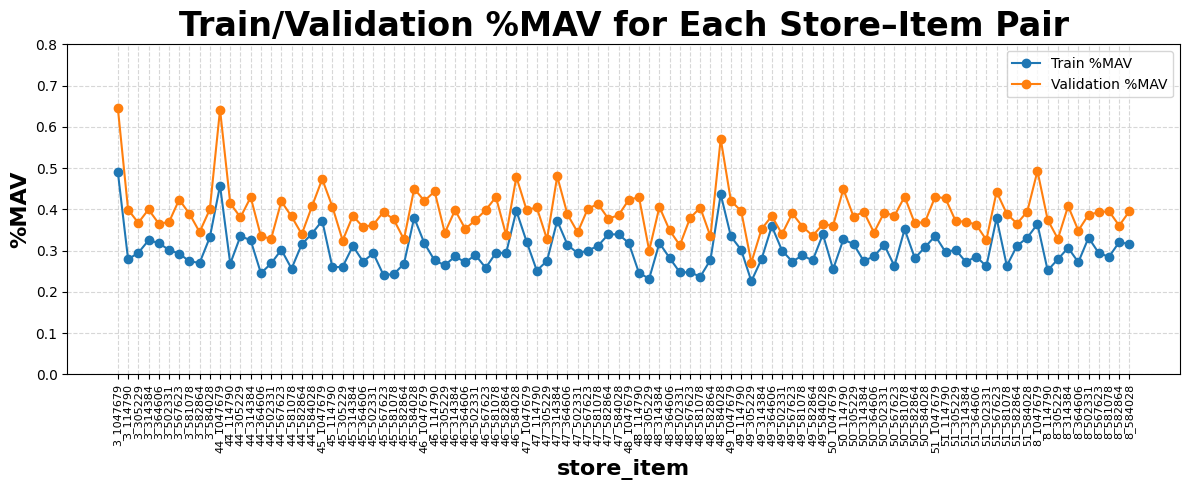

In [28]:
plot_final_percent_mae_per_sid(summary_df, title="Train/Validation %MAV for Each Store–Item Pair", 
                               fn="../output/figures/2025-06-07final_percent_mav_per_sid.tiff", y_lim=(0, .8))


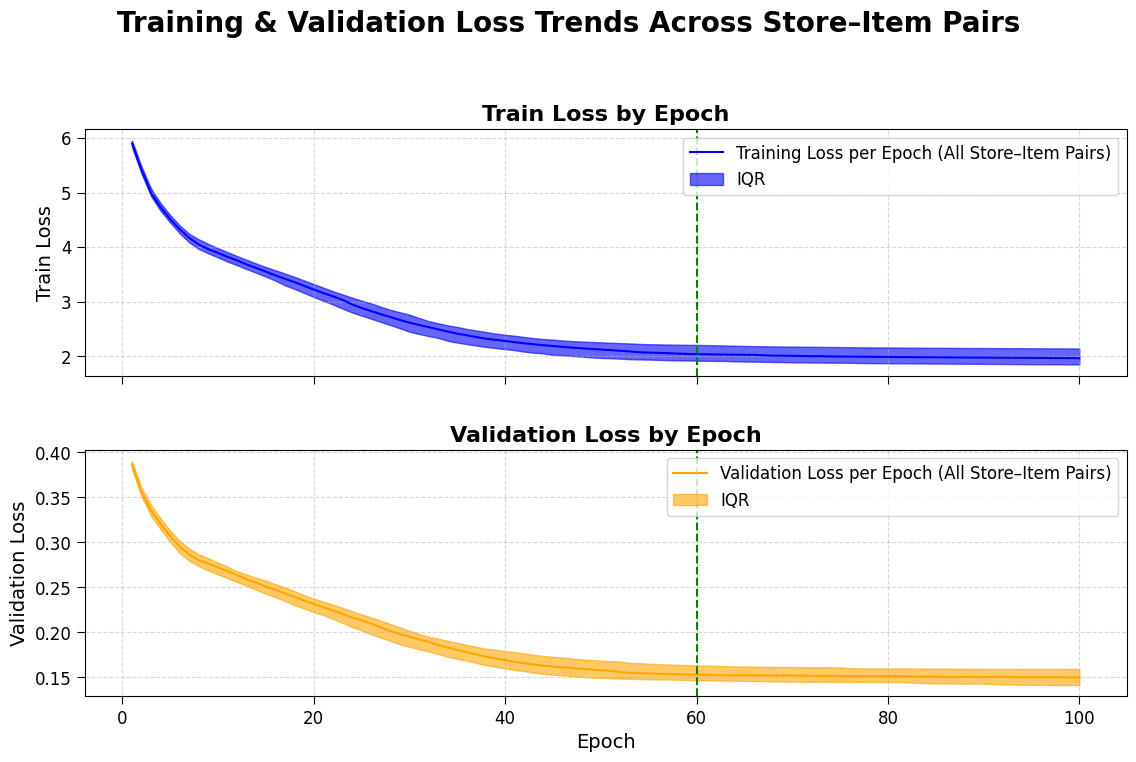

In [18]:
# plot_all_sids_losses(hist_df, 
#                      overall_title="Loss Curves for All Store Items",
# fn=f"../output/figures/all_sids_loss_curves_{today_str}.tiff")
plot_median_iqr_loss(hist_df, 
                     overall_title="Training & Validation Loss Trends Across Store–Item Pairs",
                     xvline=60,
fn=f"../output/figures/2025-06-07median_iqr_loss_curves_{today_str}.tiff")


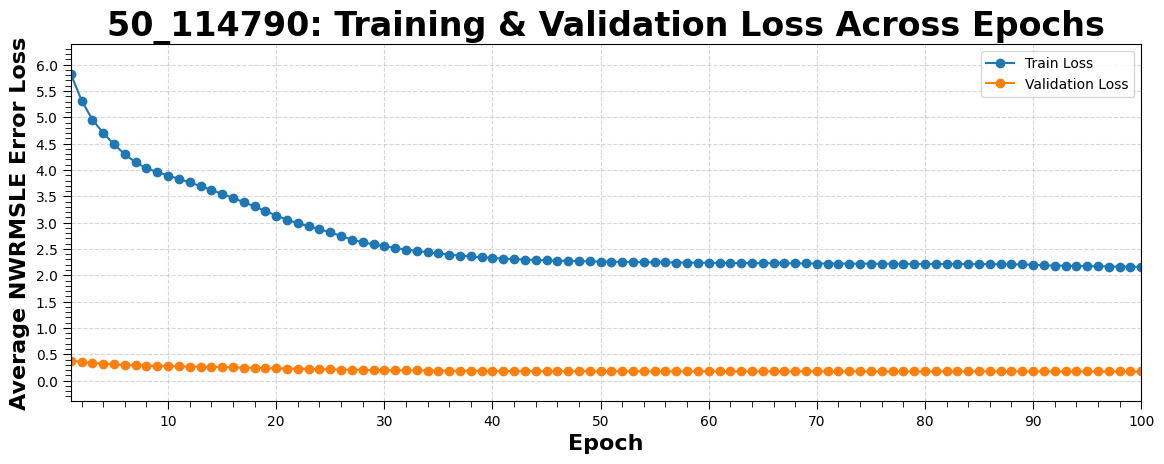

In [19]:
# to plot a single sid:
sid = "50_114790"
title = f"{sid}: Training & Validation Loss Across Epochs"
plot_loss_per_sid(hist_df, title = title,  
                  sid=sid, fn=f"../output/figures/2025-06-07_loss_curves_{sid}_{today_str}.tiff",
                  train_col="train_loss", test_col="test_loss", y_label="Average NWRMSLE Error Loss")

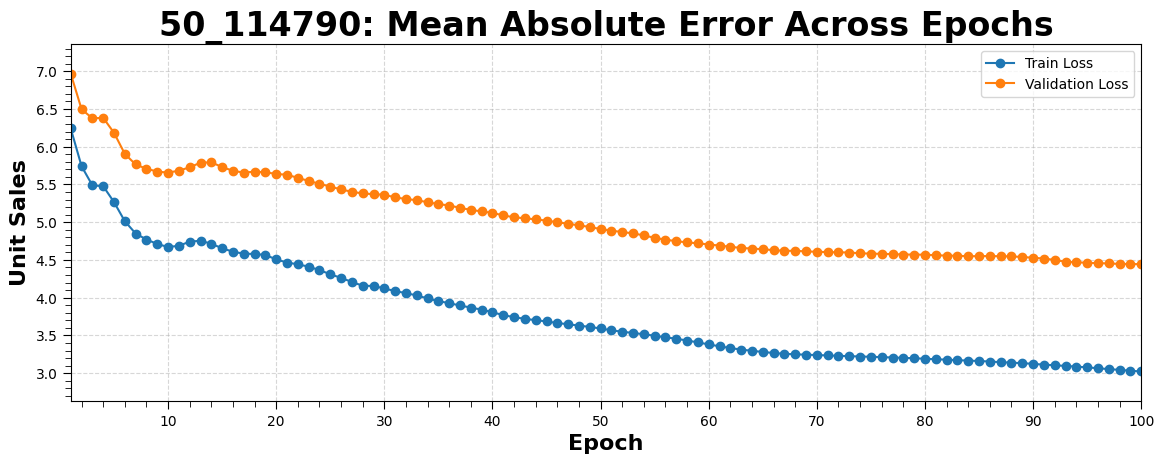

In [20]:
sid = "50_114790"
title = f"{sid}: Mean Absolute Error Across Epochs"
plot_loss_per_sid(hist_df, title=title, 
                  sid=sid, fn=f"../output/figures/2025-06-07_loss_curves_mae_{sid}_{today_str}.tiff", 
                  train_col="train_mae", test_col="test_mae", y_label="Unit Sales")